In [14]:
from google.colab import drive
drive.mount('/content/drive')

# Path to your dataset
data_dir = '/content/drive/MyDrive/Bone Break Classification'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [16]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.15,
    horizontal_flip=True,
)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

num_classes = train_generator.num_classes
class_names = list(train_generator.class_indices.keys())


Found 915 images belonging to 10 classes.
Found 224 images belonging to 10 classes.


In [17]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,608,202 (90.06 MB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [18]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

labels = train_generator.classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights_dict = dict(enumerate(class_weights))

In [19]:
base_model.trainable = True
for layer in base_model.layers[:-50]:  # freeze all except last 50 layers
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
]

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    class_weight=class_weights_dict,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 791ms/step - accuracy: 0.1086 - loss: 2.4667
Epoch 1: val_accuracy improved from -inf to 0.11607, saving model to best_model.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.1092 - loss: 2.4653 - val_accuracy: 0.1161 - val_loss: 3.0098
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.1467 - loss: 2.3580
Epoch 2: val_accuracy did not improve from 0.11607
29/29 ━━━━━━━━━━━━━━━━━━━━ 19s 645ms/step - accuracy: 0.1466 - loss: 2.3574 - val_accuracy: 0.1161 - val_loss: 2.8873
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.1280 - loss: 2.3364
Epoch 3: val_accuracy did not improve from 0.11607
29/29 ━━━━━━━━━━━━━━━━━━━━ 19s 645ms/step - accuracy: 0.1282 - loss: 2.3363 - val_accuracy: 0.1161 - val_loss: 2.7359
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - accuracy: 0.1476 - loss: 2.2707
Epoch 4: val_accuracy did not improve from 0.11607
29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 682ms/step - accuracy: 0.1478 - loss: 2.2717 - val_accuracy: 0.1161 - val_loss: 2.5389
Epoch 5/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.1762 - loss: 2.2333
Epoch 5: val_accuracy did not impr

29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 685ms/step - accuracy: 0.2339 - loss: 2.1411 - val_accuracy: 0.1205 - val_loss: 2.3374
Epoch 8/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.1950 - loss: 2.2074
Epoch 8: val_accuracy improved from 0.12054 to 0.14732, saving model to best_model.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 19s 637ms/step - accuracy: 0.1947 - loss: 2.2072 - val_accuracy: 0.1473 - val_loss: 2.3323
Epoch 9/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.2017 - loss: 2.1454
Epoch 9: val_accuracy improved from 0.14732 to 0.17411, saving model to best_model.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 682ms/step - accuracy: 0.2020 - loss: 2.1458 - val_accuracy: 0.1741 - val_loss: 2.2932
Epoch 10/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - accuracy: 0.2211 - loss: 2.1773
Epoch 10: val_accuracy did not improve from 0.17411
29/29 ━━━━━━━━━━━━━━━━━━━━ 18s 614ms/step - accuracy: 0.2211 - loss: 2.1765 - val_accuracy: 0.1696 - val_loss: 2.2916
Epoch 11/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.2411 - loss: 2.1391
Epoch 11: val_accuracy did not improve from 0.17411
29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 686ms/step - accuracy: 0.2407 - loss: 2.1395 - val_accuracy: 0.1562 - val_loss: 2.2687
Epoch 12/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.2701 - loss: 2.1006
Epoch 12: val_accuracy did not improve from 0.17411
29/29 ━━━━━━━━━━━━━━━━━━━━ 18s 606ms/step - accuracy: 0.2694 - loss: 2.1009 - val_accuracy: 0.1696 - val_loss: 2.2281
Epoch 13/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.2511 - loss: 2.0731
Epoch 13: val_accuracy i

29/29 ━━━━━━━━━━━━━━━━━━━━ 19s 643ms/step - accuracy: 0.2509 - loss: 2.0737 - val_accuracy: 0.1786 - val_loss: 2.2040
Epoch 14/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - accuracy: 0.2351 - loss: 2.1158
Epoch 14: val_accuracy did not improve from 0.17857
29/29 ━━━━━━━━━━━━━━━━━━━━ 19s 608ms/step - accuracy: 0.2351 - loss: 2.1154 - val_accuracy: 0.1562 - val_loss: 2.2238
Epoch 15/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.2080 - loss: 2.0908
Epoch 15: val_accuracy did not improve from 0.17857
29/29 ━━━━━━━━━━━━━━━━━━━━ 18s 608ms/step - accuracy: 0.2081 - loss: 2.0911 - val_accuracy: 0.1652 - val_loss: 2.2730
Epoch 16/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.2929 - loss: 1.9984
Epoch 16: val_accuracy improved from 0.17857 to 0.20089, saving model to best_model.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 22s 750ms/step - accuracy: 0.2924 - loss: 1.9996 - val_accuracy: 0.2009 - val_loss: 2.2236
Epoch 17/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.2946 - loss: 1.9974
Epoch 17: val_accuracy did not improve from 0.20089
29/29 ━━━━━━━━━━━━━━━━━━━━ 18s 616ms/step - accuracy: 0.2937 - loss: 1.9992 - val_accuracy: 0.2009 - val_loss: 2.2387
Epoch 18/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.2573 - loss: 2.0629
Epoch 18: val_accuracy did not improve from 0.20089
29/29 ━━━━━━━━━━━━━━━━━━━━ 19s 651ms/step - accuracy: 0.2574 - loss: 2.0627 - val_accuracy: 0.1920 - val_loss: 2.2121
Epoch 18: early stopping
Restoring model weights from the end of the best epoch: 13.


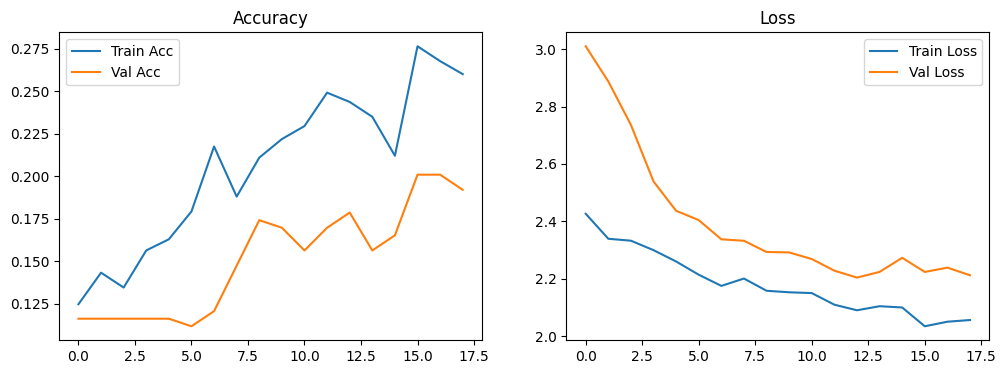

In [21]:
def plot_training(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Loss')
    plt.show()

plot_training(history)

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 377ms/step
                       precision    recall  f1-score   support

    Avulsion fracture       0.00      0.00      0.00        24
  Comminuted fracture       0.15      0.07      0.10        29
 Fracture Dislocation       0.17      0.03      0.05        31
  Greenstick fracture       0.16      0.25      0.20        24
    Hairline Fracture       0.10      0.36      0.15        22
    Impacted fracture       0.00      0.00      0.00        18
Longitudinal fracture       0.04      0.06      0.05        16
     Oblique fracture       0.12      0.06      0.08        17
Pathological fracture       0.15      0.19      0.17        26
      Spiral Fracture       0.00      0.00      0.00        17

             accuracy                           0.11       224
            macro avg       0.09      0.10      0.08       224
         weighted avg       0.10      0.11      0.08       224



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


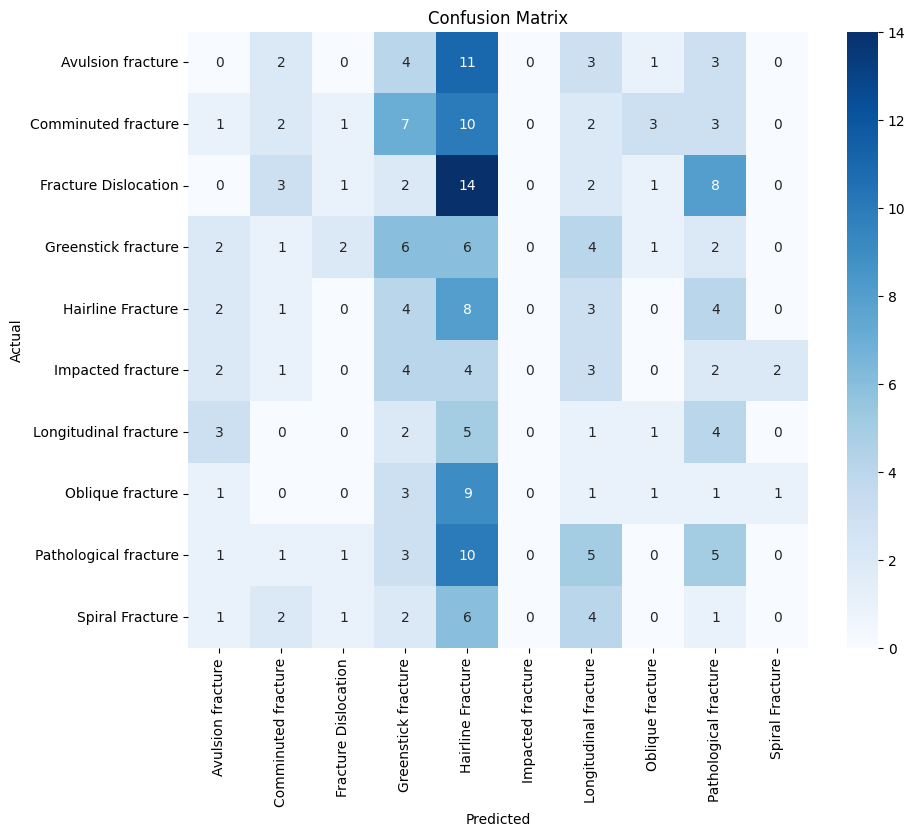

In [22]:
val_generator.reset()
preds = model.predict(val_generator)
y_pred = np.argmax(preds, axis=1)
y_true = val_generator.classes

# Classification Report
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [23]:
model.save('/content/drive/MyDrive/bone_fracture_model.h5')